In [311]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import Tensor
import torchvision
import PIL



#### Setting device (checking if gpu is available for faster training)

In [312]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Loading the dataset

In [313]:
def load_cifar10(batch_size):
    # Transformations for the training data
    train_trans = transforms.Compose([
        transforms.RandomCrop(size=(32, 32), padding=4),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Transformations for the test data (minimal, without augmentation)
    test_trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Loading the datasets
    train = torchvision.datasets.CIFAR10(root="../data", train=True, transform=train_trans, download=True)
    test = torchvision.datasets.CIFAR10(root="../data", train=False, transform=test_trans, download=True)
    
    # Creating the DataLoaders
    train_loader = DataLoader(train, batch_size, shuffle=True, pin_memory=False)
    test_loader = DataLoader(test, batch_size, shuffle=False, pin_memory=False)
    
    return train_loader, test_loader


In [314]:
BATCH_SIZE = 64
train_iter, test_iter = load_cifar10(BATCH_SIZE)
for data in train_iter:
    print(data[0].size())
    print(data[1].size())
    break

Files already downloaded and verified
Files already downloaded and verified
torch.Size([64, 3, 32, 32])
torch.Size([64])


### CIFAR-10 Dataset Analysis
Cifar-10 holds images if dimension 32x32
Cifar images also contain colour using the rgb format
Therefore each item in the dataset is of size 3x32x32


In [315]:
# hyper params
B1_OUT = 32
B2_OUT = 64
B3_OUT = 128
B4_OUT = B3_OUT
L1_OUT = 1024
L2_OUT = 512


class Model(torch.nn.Module):
    def __init__(self, in_channels, out_features):
        super(Model, self).__init__()
        self.maxpool = nn.MaxPool2d(2,2) 
        self.avgpool = nn.AvgPool2d(2,2) 
        self.block1 = Block(6,in_channels,B1_OUT, kernel_size=5, padding=2) 
        self.resid1 = Block(6,B1_OUT,B1_OUT,kernel_size=5,padding=2)
        self.block2 = Block(6,B1_OUT,B2_OUT, kernel_size=3, padding=1)
        self.resid2 = Block(6,B2_OUT,B2_OUT,kernel_size=3,padding=1,residual=True)
        self.block3 = Block(6,B2_OUT,B3_OUT,kernel_size=3, padding=1)
        self.resid3 = Block(6,B3_OUT,B3_OUT,kernel_size=3,padding=1, residual=True)
        self.resid3_2 = Block(6,B3_OUT,B3_OUT,kernel_size=3,padding=1, residual=True)

        self.d1 = nn.Dropout(0.1)        
        self.d2 = nn.Dropout(0.1)        
        self.d3 = nn.Dropout(0.15)        
        self.d4 = nn.Dropout(0.15)
        self.d5 = nn.Dropout(0.15)
        
        self.spatial_pool = nn.AdaptiveAvgPool2d(1)
        # Linear Layers
        self.activation = nn.ReLU()
        # self.activation = nn.Sigmoid()
        
        self.linear1 = nn.Linear(B4_OUT,L1_OUT)
        self.linear2 = nn.Linear(L1_OUT,L2_OUT)
        self.linear3 = nn.Linear(L2_OUT, out_features)

    def forward(self, x):
        out = self.activation(self.block1(x))
        out = self.activation(self.resid1(out))
        out = self.avgpool(out) #16x16
        out = self.d1(out)
        out = self.activation(self.block2(out))
        out = self.activation(self.resid2(out))
        out = self.maxpool(out) # 8x8
        out = self.d2(out)
        out = self.activation(self.block3(out))
        out = self.activation(self.resid3(out))
        out = self.activation(self.resid3_2(out))
        out = self.maxpool(out) # 4x4
        out = self.d3(out)
        ## 

        out = self.spatial_pool(out)
        # flatten for linear layers
        out = out.reshape(-1 , B4_OUT)

        out = self.linear1(out)
        out = self.activation(out)
        out = self.d4(out)

        out = self.linear2(out)
        out = self.activation(out)
        out = self.d5(out)

        out = self.linear3(out)
        return out


class Block(torch.nn.Module):
    def __init__(self, k, in_channels, out_channels, padding=2, kernel_size=5, stride=1, residual=False):
        super(Block, self).__init__()
        self.residual = residual
        L1_OUT = 512
        L2_OUT = 512
        
        self.k = k
        self.out_channels = out_channels
        self.in_channels = in_channels
        # defining weight calculations (a)
        self.spatialAvgPool = nn.AdaptiveAvgPool2d(1)
        # flatten
        self.aLinear1 = nn.Linear(in_features=in_channels, out_features=L1_OUT)
        self.aLinear2 = nn.Linear(in_features=L1_OUT,out_features=L2_OUT)
        self.aLinear3 = nn.Linear(L2_OUT,k)
        self.activation = nn.ReLU()
        # defining the convolution section
        # creates k convolutions
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size ,padding=padding, stride=stride) for _ in range(k)])
        # self.batch_norms = nn.ModuleList([nn.BatchNorm2d(out_channels) for _ in range(k)])
        self.batch_norm = nn.BatchNorm2d(out_channels)

    def forward(self, x: Tensor) -> Tensor:

        # apply spatial average pooling
        pooled: Tensor = self.spatialAvgPool(x)
        # flatten the output for the linear layer
        pooled = pooled.view(pooled.size(0), -1)
        a: Tensor = self.activation(self.aLinear1(pooled))
        a = self.activation(self.aLinear2(a))
        a = self.aLinear3(a)

        O: Tensor = torch.zeros_like(self.convs[0](x))

        # Apply the convolutions and accumulate the weighted sum
        for i in range(self.k):
            conv = self.convs[i](x)
            # conv = self.activation(conv)
            O = O + a[:, i].view(-1, 1, 1, 1) * conv # this calculates a_1 conv_1 + ... + a_k conv_k, also applies activation function to it
        O = self.batch_norm(O)
        
        if self.residual:
            O= O + x
        
        return O # returns [batchsize, c, h, w]


### Training The Model

In [316]:
class Accumulator:
    
    def __init__(self, n) -> None:
        self.data = [0.0] * n
    
    # deletes all data and information stored
    def reset(self) -> None:
        self.data = [0.0] * len(self.data)
    
    # takes in n inputs, for each arg it adds it to its corresponding index in data
    def add(self, *args) -> None:
        self.data = [a + float(b) for a,b in zip(self.data, args)]
    
    # allows the indexing operator to be used
    def __getitem__(self, idx) -> any:
        return self.data[idx]
    
    def toList(self) -> list:
        return self.data
    
    def percentage(self, index, total):
        return 100 * self[index] / total if total > 0 else 0

In [317]:
import matplotlib.pyplot as plt

def trainingLoop(num_epoch, train_iter, test_iter, net, loss_function, optimizer) -> tuple[int, list[float], list[float], list[float]]:
    loss_values = [] 
    training_accuracy_values = []  
    testing_accuracy_values = []

    for epoch in range(num_epoch):
        # train on trianing set to obtain updated weights
        train_metrics = train(train_iter, net, loss_function, optimizer) # tuple (loss , accuracy)
        # testing new weights on unseen data
        test_accuracy = test(test_iter, net)
        # data for plotting
        loss_values.append(train_metrics[0])
        training_accuracy_values.append(train_metrics[1]) 
        testing_accuracy_values.append(test_accuracy)

        print(f'Epoch {epoch+1}, Average Loss: {loss_values[-1]}, Training Accuracy: {training_accuracy_values[-1]}, Testing Accuracy {testing_accuracy_values[-1]}')
        
    return(num_epoch, loss_values, training_accuracy_values, testing_accuracy_values)


def test(data_iter, net) -> float:
    net.eval() # set to testing mode
    
    metrics = Accumulator(2) # [correct, total]
    
    with torch.no_grad():
        for X, y in data_iter:
            # Move data to the specified device
            X, y = X.to(device), y.to(device)
            # Get model predictions
            y_hat = net(X)
            # Convert probabilities to predicted class labels
            _, predicted_labels = torch.max(y_hat, 1)
            # Accumulate the number of correct predictions and the total
            metrics.add((predicted_labels == y).sum().item(), y.size(0))
    
    # Calculate accuracy
    accuracy = metrics[0] / metrics[1]
    
    # Set the network back to training mode
    net.train()
    
    return accuracy

def train(data_iter, net, loss_function, optimizer) -> tuple[float , float]:
    net.train()
    
    metrics = Accumulator(3)  # [sum of losses, correct predictions, total predictions]
    for X, Y in data_iter:  # get x and corresponding y value
        X, Y = X.to(device), Y.to(device)
        
        y_hat = net(X)  # get prediction
        loss = loss_function(y_hat, Y)  # loss of this specific value
        optimizer.zero_grad()  # clear gradient
        loss.backward()  # calculate derivative of loss w.r.t the weight
        optimizer.step()  # change weight values accordingly

        metrics.add(loss.item(), (torch.max(y_hat, 1)[1] == Y).float().sum().item(), Y.size(0))
    # Calculate average loss and accuracy from the accumulated values
    avg_loss = metrics[0] / metrics[2]
    accuracy = metrics[1] / metrics[2]
    
    return (avg_loss, accuracy)


In [318]:
# Function to plot the data
def plotTraining(num_epoch, loss_values, train_accuracy_values, test_accuracy_values):
    fig, ax1 = plt.subplots()

    # Training Loss
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color=color)
    ax1.plot(range(1, num_epoch+1), loss_values, '-o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis to share the same x-axis
    ax2 = ax1.twinx()  

    # Training Accuracy and Testing Accuracy
    color_train = 'tab:blue'
    color_test = 'tab:green'
    ax2.set_ylabel('Accuracy', color=color_train)  # We already handled the x-label with ax1
    # Plot training accuracy on ax2
    ax2.plot(range(1, num_epoch+1), train_accuracy_values, '-s', color=color_train, label='Train Accuracy')
    # Plot testing accuracy on ax2 as well
    ax2.plot(range(1, num_epoch+1), test_accuracy_values, '-^', color=color_test, label='Test Accuracy')
    ax2.tick_params(axis='y', labelcolor=color_train)
    ax2.legend(loc='upper left')

    fig.tight_layout()  # Otherwise the right y-label is slightly clipped
    plt.title('Training Loss and Accuracy')
    plt.show()


In [319]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_normal_(m.weight)
        # torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')


In [320]:
model = Model(3, 10).to(device)
# model = Model(3, 10)
model.apply(init_weights)

loss = nn.CrossEntropyLoss()
lr = 0.002
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-5) 

Epoch 1, Average Loss: 0.030918090224266052, Training Accuracy: 0.24188, Testing Accuracy 0.2943
Epoch 2, Average Loss: 0.025905261886119843, Training Accuracy: 0.3732, Testing Accuracy 0.4092
Epoch 3, Average Loss: 0.02240656903028488, Training Accuracy: 0.4754, Testing Accuracy 0.4946
Epoch 4, Average Loss: 0.01986025170445442, Training Accuracy: 0.54246, Testing Accuracy 0.5618
Epoch 5, Average Loss: 0.01816337364912033, Training Accuracy: 0.5879, Testing Accuracy 0.3469
Epoch 6, Average Loss: 0.017213659014701843, Training Accuracy: 0.61052, Testing Accuracy 0.6506
Epoch 7, Average Loss: 0.01596004326581955, Training Accuracy: 0.64092, Testing Accuracy 0.6737
Epoch 8, Average Loss: 0.015095186280012132, Training Accuracy: 0.66316, Testing Accuracy 0.6774
Epoch 9, Average Loss: 0.014481649401187896, Training Accuracy: 0.67778, Testing Accuracy 0.71
Epoch 10, Average Loss: 0.014039850651621819, Training Accuracy: 0.6883, Testing Accuracy 0.7176
Epoch 11, Average Loss: 0.0135667706477

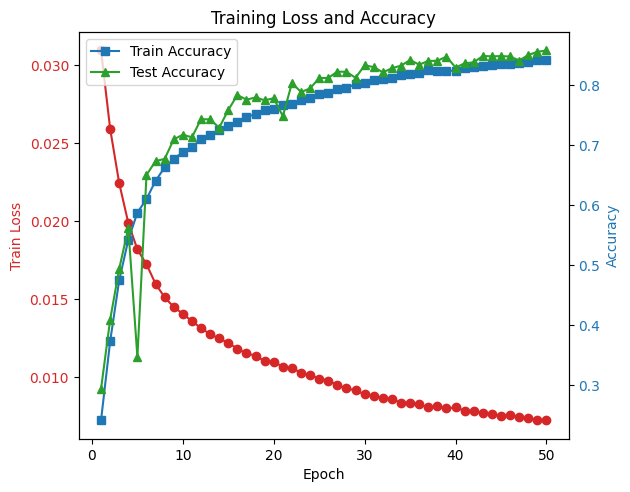

In [321]:
num_epochs = 50
# mu.train_ch3(model, train_iter, test_iter, loss, num_epochs, optimizer)
params = trainingLoop(num_epochs,train_iter,test_iter ,model, loss, optimizer)
plotTraining(*params) # spreads tuple

Epoch 1, Average Loss: 0.007156219213008881, Training Accuracy: 0.84488, Testing Accuracy 0.8572
Epoch 2, Average Loss: 0.0071513528144359585, Training Accuracy: 0.84374, Testing Accuracy 0.8574
Epoch 3, Average Loss: 0.0070857639181613925, Training Accuracy: 0.8441, Testing Accuracy 0.8442
Epoch 4, Average Loss: 0.006988539275228977, Training Accuracy: 0.84622, Testing Accuracy 0.8551
Epoch 5, Average Loss: 0.00706690032094717, Training Accuracy: 0.84538, Testing Accuracy 0.8582
Epoch 6, Average Loss: 0.006885261659622192, Training Accuracy: 0.84882, Testing Accuracy 0.8577
Epoch 7, Average Loss: 0.0068440649971365924, Training Accuracy: 0.85014, Testing Accuracy 0.85
Epoch 8, Average Loss: 0.006790343952476978, Training Accuracy: 0.84996, Testing Accuracy 0.8523
Epoch 9, Average Loss: 0.006900264912247658, Training Accuracy: 0.84816, Testing Accuracy 0.8617
Epoch 10, Average Loss: 0.006815681962072849, Training Accuracy: 0.8518, Testing Accuracy 0.8589


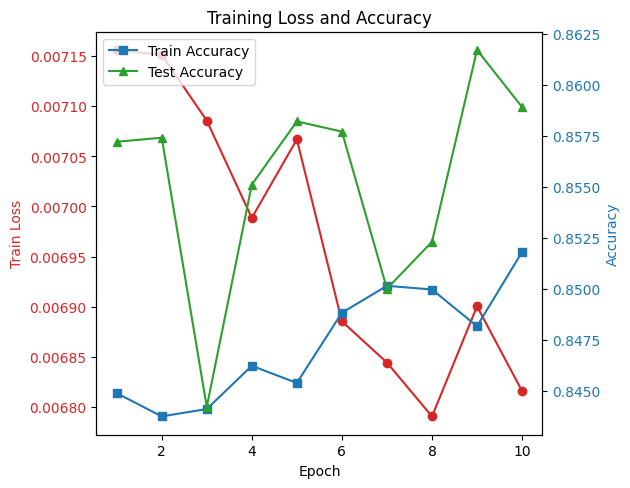

'\nincrease mlp layer width -> double\nincrease channels\nincrease k\n\n\n=======\n\nsgd\n\n1 max 2 max 3 (2 resids)\n\n'

In [322]:
num_epochs = 10
# mu.train_ch3(model, train_iter, test_iter, loss, num_epochs, optimizer)
params = trainingLoop(num_epochs,train_iter,test_iter ,model, loss, optimizer)
plotTraining(*params) # spreads tuple

"""
increase mlp layer width -> double
increase channels
increase k


=======

sgd

1 max 2 max 3 (2 resids)

"""

Epoch 1, Average Loss: 0.0067253030407428745, Training Accuracy: 0.85226, Testing Accuracy 0.8654
Epoch 2, Average Loss: 0.006612309257090092, Training Accuracy: 0.8546, Testing Accuracy 0.8655
Epoch 3, Average Loss: 0.006616358604133129, Training Accuracy: 0.85462, Testing Accuracy 0.8597
Epoch 4, Average Loss: 0.006671310767233372, Training Accuracy: 0.85444, Testing Accuracy 0.85
Epoch 5, Average Loss: 0.00660943703263998, Training Accuracy: 0.85734, Testing Accuracy 0.8613


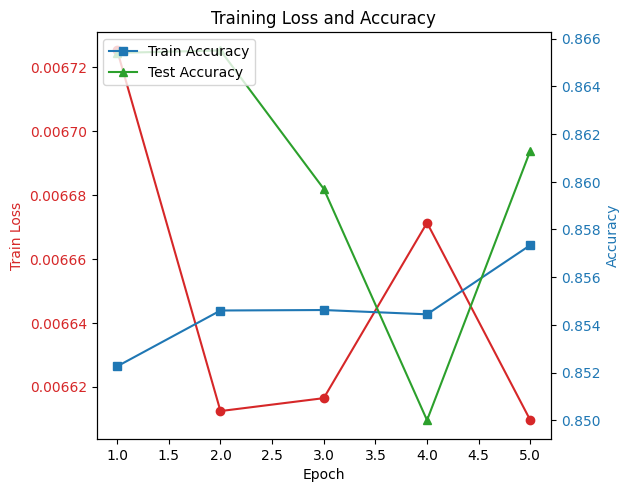

'\nincrease mlp layer width -> double\nincrease channels\nincrease k\n\n\n=======\n\nsgd\n\n1 max 2 max 3 (2 resids)\n\n'

In [323]:
num_epochs = 5
# mu.train_ch3(model, train_iter, test_iter, loss, num_epochs, optimizer)
params = trainingLoop(num_epochs,train_iter,test_iter ,model, loss, optimizer)
plotTraining(*params) # spreads tuple

"""
increase mlp layer width -> double
increase channels
increase k


=======

sgd

1 max 2 max 3 (2 resids)

"""